# Initialise environment

simple analysis of the CAFE60 BGC output - version for the OOD

Looking at how to determine what ensemble members to use in the pre-industrial simulation.  I want 10 members.  
Nic used member 25 and I used the seasonal cycle in the SO to identify member 79.  No I need a few more members.


In [1]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
#import xrft
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%config Completer.use_jedi = False

from eofs.xarray import Eof

# Start Cluster

# non OOD cluster

walltime = '04:00:00'
cores = 2
memory = '8GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33+gdata/zv2+gdata/xv83'],
                     header_skip=["select"])

cluster.scale(jobs=6)
client = Client(cluster)
client

#
client.shutdown()
cluster.shutdown()

In [2]:
# in the OOD cluster

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=48)

In [3]:
cluster

Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.145:33359,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.145:33359,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Read in data

and create useful variables for further calculations 

In [5]:
def climatology(dsx,TIME1):
    clim = dsx.groupby(TIME1+'.month').mean(dim=TIME1)
    anom = dsx.groupby(TIME1+'.month') - clim
    season=dsx.groupby(TIME1+'.season').mean(dim=TIME1)
    return(clim,season,anom)

In [6]:
file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
#file3='/home/mat236/area.nc'

#dgrid=xr.open_dataset(file1)
docn = xr.open_zarr(file1,consolidated=True)
darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
#darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
darea

dbgc = xr.open_zarr(file2)

In [7]:

darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
darea

<xarray.Dataset>
Dimensions:        (zt: 50, zb: 50, grid_x_T: 360, grid_y_T: 300, grid_x_C: 360, grid_y_C: 300, vertex: 4, i_atmXocn: 111817, i_atmXlnd: 5285, i_lndXocn: 111817, xba: 145, yba: 91, xta: 144, yta: 90, xbl: 145, ybl: 91, xtl: 144, ytl: 90, xto: 360, yto: 300, time: 1, yt: 300, xt: 360)
Coordinates: (12/20)
  * zt             (zt) float32 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * zb             (zb) float32 10.0 20.0 30.0 ... 5.333e+03 5.665e+03 6e+03
  * grid_x_T       (grid_x_T) float32 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * grid_y_T       (grid_y_T) float32 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * grid_x_C       (grid_x_C) float32 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * grid_y_C       (grid_y_C) float32 -77.75 -77.51 -77.26 ... 89.1 89.55 90.0
    ...             ...
  * ytl            (ytl) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * xto            (xto) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * yto            (yto) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * time           (time) object 2009-03-18 12:00:00
  * xt             (xt) float64 -279.5 -278.6 -277.6 ... 77.65 78.59 79.53
  * yt             (yt) float64 -77.88 -77.63 -77.38 ... 78.71 78.78 78.82
Dimensions without coordinates: i_atmXocn, i_atmXlnd, i_lndXocn
Data variables: (12/125)
    x_T            (grid_y_T, grid_x_T) float64 ...
    y_T            (grid_y_T, grid_x_T) float64 ...
    x_vert_T       (vertex, grid_y_T, grid_x_T) float64 ...
    y_vert_T       (vertex, grid_y_T, grid_x_T) float64 ...
    area_T         (grid_y_T, grid_x_T) float64 ...
    angle_T        (grid_y_T, grid_x_T) float64 ...
    ...             ...
    J_OCN_LNDxOCN  (i_lndXocn) int32 ...
    AREA_ATM       (yta, xta) float64 ...
    AREA_LND       (ytl, xtl) float64 ...
    AREA_LND_CELL  (ytl, xtl) float64 ...
    AREA_OCN       (yto, xto) float64 ...
    EXT            (time, yt, xt) float32 ...
Attributes: (12/22)
    filename:                  ice_daily_2009_03_15.nc
    xname:                     longitude
    yname:                     latitude
    vertex_convention:         SWCCW
    join_lat:                  65.0
    y_boundary_type:           fold_north_edge
    ...                        ...
    title:                     AccessOcean-AM2
    grid_type:                 regular
    grid_tile:                 N/A
    history:                   Wed Jan 16 15:50:28 2019: ncap2 -A -s where (E...
    nco_openmp_thread_number:  1
    NCO:                       4.3.2

In [8]:
docn

,Array,Chunk
Bytes,1.38 TiB,118.65 MiB
Shape,"(731, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12428 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.38 TiB,118.65 MiB
Shape,"(731, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12428 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
# create a thickness variable on the tracer depth grid
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
#print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([ 10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.92337036,  18.17451477,  31.96699524,  50.95071411,
        73.26739502,  96.73260498, 119.04928589, 138.03302002,
       151.82550049, 159.07659912, 160.26977539, 162.41760254,
       166.66052246, 172.89404297, 180.96447754, 190.67321777,
       201.78149414, 214.01513672, 227.07348633, 240.63476562,
       254.36523438, 267.92651367, 280.98486328, 293.21850586,
       304.3269043 , 314.03515625, 322.10644531, 328.33935547,
       332.58203125, 334.73046875])
Coordinates:
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03

In [10]:
# create a thickness variable on the tracer depth grid
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
#print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([ 10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.92337036,  18.17451477,  31.96699524,  50.95071411,
        73.26739502,  96.73260498, 119.04928589, 138.03302002,
       151.82550049, 159.07659912, 160.26977539, 162.41760254,
       166.66052246, 172.89404297, 180.96447754, 190.67321777,
       201.78149414, 214.01513672, 227.07348633, 240.63476562,
       254.36523438, 267.92651367, 280.98486328, 293.21850586,
       304.3269043 , 314.03515625, 322.10644531, 328.33935547,
       332.58203125, 334.73046875])
Coordinates:
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03

# Anthropogenic CO2 flux

In [11]:
ens=23
t1 = '2000-01-16'
t2 = '2018-12-31'
x1=-250 ; x2=-75
y1=-3 ; y2=3
totd=dbgc.stf10[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
natd=dbgc.stf07[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
totd.shape

(228, 18, 175)

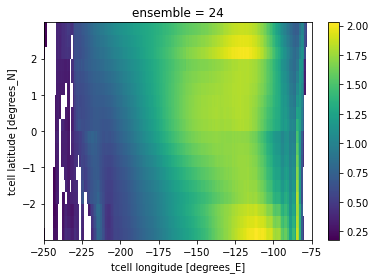

In [12]:
tota = (totd-natd).compute()
(tota.mean(axis=0)*86400).plot()

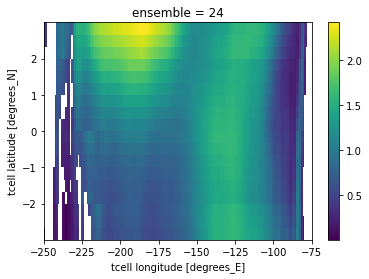

In [13]:
(tota.sel(time=slice('2015-12-01','2016-03-16')).mean(axis=0)*86400).plot()

In [14]:
# total flux into ocean

area_r=darea.area_T.rename({'grid_y_T':'yt_ocean','grid_x_T':'xt_ocean' })
area_s = area_r.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
area_tmp=area_s.assign_coords({'yt_ocean': tota.yt_ocean}).load()
tflux_aco2 = (tota.mean(axis=0)*86400*365)*area_tmp.compute()

iflux=tflux_aco2.sum(axis=(0,1))*12e-15*1e-3  # mmol C/y to PgC/y
print(iflux.values, (iflux*20).values)

0.06223836049209311 1.244767209841862


Comment
average uptake per year and uptake over 20 years is

0.062 and 1.24

In [15]:
#  write output
dir='odirs/'
tflux_aco2.to_netcdf(dir+'eq_aco2flux.nc')

# Anthropogenic CO2 concentration

In [16]:
ens=23
t1 = '2000-01-16'
t2 = '2018-12-31'

x1=-227 ; x2=-75
y1=-20 ; y2=20
adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
aco2=adic-dic

aco2.nbytes*1e-6


679.2576

In [17]:

cthickness=mdepth
cthickness
omask=(aco2[-1,0,:,:]*0).copy()
cinv = aco2*cthickness*1e-3 #mmol to mols

mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
mcinv=cinv.sum(axis=1)+omask

# difference between end and start
aco2_c300 = (mcinv300[-1:,:,:]-mcinv300[0,:,:])
aco2_call = (mcinv[-1:,:,:]-mcinv[0,:,:])

# integrate multiple by grid cell area
area_r=darea.area_T.rename({'grid_y_T':'yt_ocean','grid_x_T':'xt_ocean' })
area_s = area_r.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
area_tmp=area_s.assign_coords({'yt_ocean': aco2.yt_ocean}).load()
i_aco2_300=aco2_c300*area_tmp 
i_aco2_all=aco2_call*area_tmp 

# equatorial Pacific
# 160E  and 110W  - -200 and -110
x1e=-227 ; x2e=-75
y1e=-3 ; y2e=3
tmp1=i_aco2_300.sel(xt_ocean=slice(x1e,x2e),yt_ocean=slice(y1e,y2e)).compute()
tmp2=i_aco2_all.sel(xt_ocean=slice(x1e,x2e),yt_ocean=slice(y1e,y2e)).compute()

sum1=tmp1.sum(axis=(1,2))*12*1e-15 #Pg C
sum=tmp2.sum(axis=(1,2))*12*1e-15 #Pg C

print(sum.values,sum1.values)

[0.73624594] [0.57803383]


In [18]:

tmp1.to_netcdf(dir+'eq_iaco2_300.nc')
tmp2.to_netcdf(dir+'eq_iaco2_all.nc')

Text(0.5, 1.0, 'total')

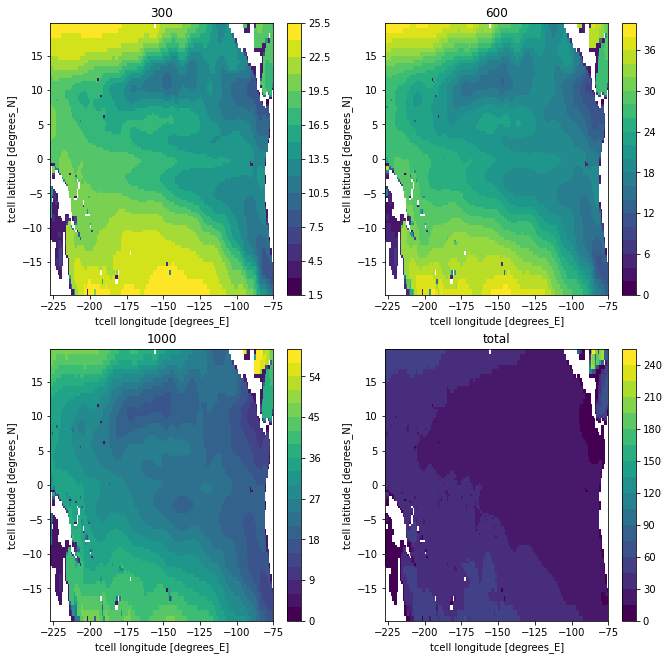

In [19]:
plt.figure(figsize=(11,11))
plt.subplot(2,2,1)
mcinv300[-1,:,:].plot(levels=21)
plt.title('300')
plt.subplot(2,2,2)
mcinv600[-1,:,:].plot(levels=21)
plt.title('600')
plt.subplot(2,2,3)
mcinv1000[-1,:,:].plot(levels=21)
plt.title('1000')
plt.subplot(2,2,4)
mcinv[-1,:,:].plot(levels=21)
plt.title('total')

The numbers give the total inventory in tropical pacific (3N - 3S) in PgC 

for entire ocean 0.7 PgC 
for upper 300 m 0.6 PgC 


End of calculations with aco2 and fluxes

# Plot aco2 concentrations on a few zonal sections

Text(0.5, 1.0, '-190W')

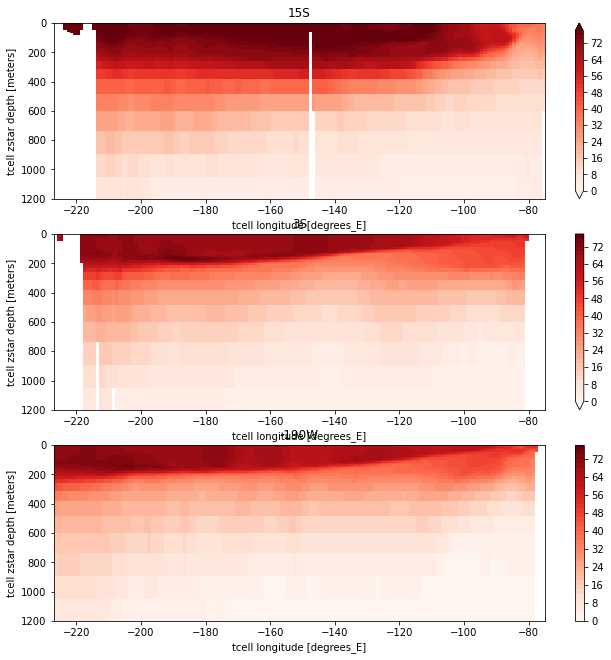

In [20]:

plt.figure(figsize=(11,11))
plt.subplot(3,1,1)
aa=aco2[-1:,:,:,:].sel(yt_ocean=-15,method='nearest')
aa.sel(st_ocean=slice(0,4000)).plot(yincrease=False,ylim=[1200,0],levels=np.arange(0,80,2),cmap='Reds')#,title='Lat=3S')
plt.title('15S')

plt.subplot(3,1,2)
aa=aco2[-1:,:,:,:].sel(yt_ocean=-3,method='nearest')
aa.sel(st_ocean=slice(0,4000)).plot(yincrease=False,ylim=[1200,0],levels=np.arange(0,80,2),cmap='Reds')#,title='Lat=3S')
plt.title('3S')

plt.subplot(3,1,3)
aa=aco2[-1:,:,:,:].sel(yt_ocean=3,method='nearest')
aa.sel(st_ocean=slice(0,4000)).plot(yincrease=False,ylim=[1200,0],levels=np.arange(0,80,2),cmap='Reds')#,title='Lat=3S')
plt.title('-190W')

# Transport

In [21]:
print(cluster)

SLURMCluster(b5243f48, 'tcp://10.0.128.145:33359', workers=16, threads=32, memory=700.32 GiB)


In [22]:
print(client)

<Client: 'tcp://10.0.128.145:33359' processes=16 threads=32, memory=700.32 GiB>


In [23]:
ens=23
t1 = '2000-01-16'
t2 = '2018-12-31'
x1=-227 ; x2=-75
y1=-3.0 ; y2=3

vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
tv_gm=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


In [24]:
from xgcm import Grid
tv_gm

,Array,Chunk
Bytes,118.98 MiB,32.06 kiB
Shape,"(228, 50, 18, 152)","(1, 3, 18, 152)"
Count,28731 Tasks,3876 Chunks
Type,float32,numpy.ndarray


In [25]:
# need to rename axis to work !! aco2_face=aco2.interp_like(tv)
aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

aco2_face

,Array,Chunk
Bytes,118.98 MiB,32.06 kiB
Shape,"(228, 50, 18, 152)","(1, 3, 18, 152)"
Count,76846 Tasks,3876 Chunks
Type,float32,numpy.ndarray


In [26]:
trans_aco2 = aco2_face*tv
trans_aco2_gm = aco2_face*tv_gm

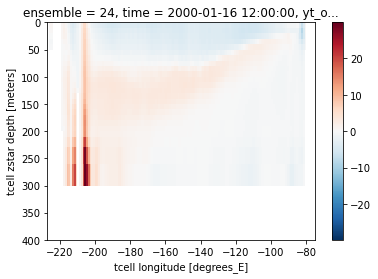

In [27]:
trans_aco2[0,0:24,0,:].plot(ylim=[400,0])

In [28]:
trans_s_gm=trans_aco2_gm[:,0:24,0,:].sum(axis=(1,2)).compute()
trans_n_gm=trans_aco2_gm[:,0:24,17,:].sum(axis=(1,2)).compute()
trans_s=trans_aco2[:,0:24,0,:].sum(axis=(1,2)).compute()
trans_n=trans_aco2[:,0:24,17,:].sum(axis=(1,2)).compute()

mtrans_s=tv[:,0:24,0,:].sum(axis=(1,2)).compute()
mtrans_n=tv[:,0:24,17,:].sum(axis=(1,2)).compute()

In [29]:
print(trans_s.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_s_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

print(mtrans_s.mean(axis=0).values )
print(mtrans_n.mean(axis=0).values )

0.1667891343339844
0.14469942515625
0.2852120998476563
-0.28130866523437503
7.0099435
13.837028


The transport across the 3S and 3N for anthropogenic CO2 and mass.  The aco2 is separated into eulerian and gm



In [30]:
tv_gm

,Array,Chunk
Bytes,118.98 MiB,32.06 kiB
Shape,"(228, 50, 18, 152)","(1, 3, 18, 152)"
Count,28731 Tasks,3876 Chunks
Type,float32,numpy.ndarray


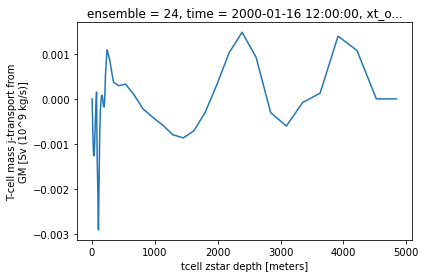

In [31]:
tv_gm[0,:,0,75].plot()

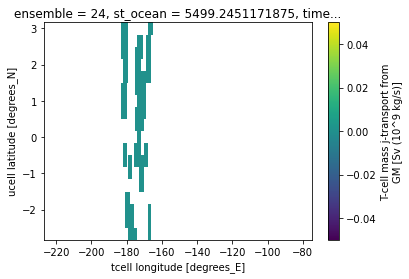

In [35]:
tv_gm[0,48,:,:].plot()